In [1]:
# 初始化
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az
import scipy.io as sio

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['Times New Roman']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
print (os.path.abspath('.'))

/Users/zhaolong/Documents/junior>/the scientific research practice


In [117]:
data1 = pd.read_csv('training_data.csv')
data1 = data1.rename(columns={'cnt': 'motiv','mask':'masked'})

In [118]:
data1

,Unnamed: 0,RT,true,inter,motiv,masked,noise,ID,type,eta_pro,eta_re
0,1,634.781100,1,0,0,0,0,1,1,-90,0
1,2,538.203300,1,0,0,0,0,1,2,90,-90
2,3,512.262000,1,0,0,0,0,1,1,-90,0
3,4,456.118800,1,0,0,0,0,1,1,-90,0
4,5,511.307800,1,0,0,0,0,1,1,-90,0
...,...,...,...,...,...,...,...,...,...,...,...
2353,2486,344.195769,1,0,0,1,0,10,4,-90,-90
2354,2487,359.948543,1,0,0,1,0,10,4,-90,-90
2355,2488,351.888270,1,0,0,1,0,10,4,-90,-90
2356,2489,344.257520,1,0,0,1,0,10,4,-90,-90


In [7]:
subject_idxs, subject = pd.factorize(data1.ID)
coords = {
    "subject": subject,
    "obs_id": np.arange(len(subject_idxs)),
}

In [38]:
# define model
with pm.Model(coords = coords) as model_AX:
    subject_idxs = pm.Data("subject_idxs", subject_idxs, dims="obs_id") #定义分组
    b = pm.Normal("mu_b", mu=400, sigma=50, dims="subject")
    beta_pro = pm.Uniform("beta_pro",lower=0,upper=1, dims="subject")
    beta_re = pm.Uniform("beta_re",lower=0,upper=1,dims="subject")
    y = b[subject_idxs] + data1['eta_pro'].values * beta_pro[subject_idxs] + data1['eta_re'].values * beta_re[subject_idxs]
    
    eps = pm.HalfCauchy("eps", 5)
    RT = pm.Normal("RT",y,sigma=eps,observed = data1.RT, dims = "obs_id")
    

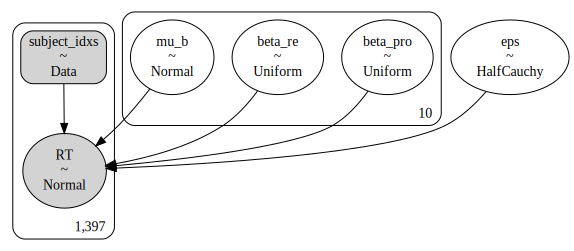

In [39]:
pm.model_graph.model_to_graphviz(model_AX) #画出图模型

In [40]:
with model_AX:
    trace1 = pm.sample(20000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta_re, beta_pro, mu_b]


/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 177 seconds.


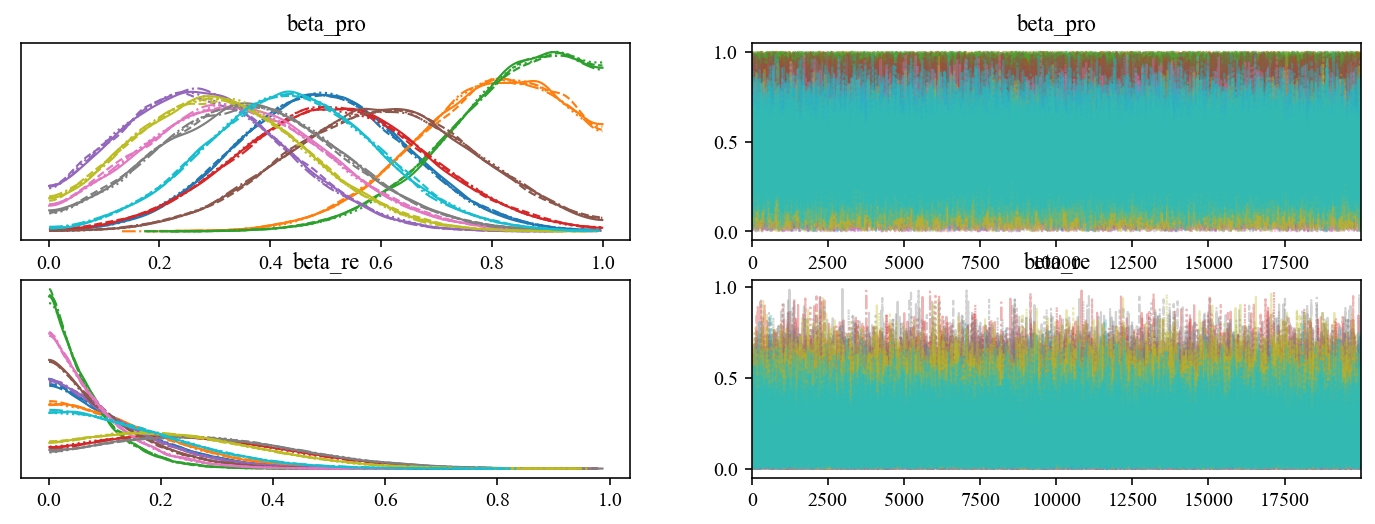

In [42]:
az.plot_trace(trace1, var_names=["beta_pro", "beta_re"],coords={"subject": subject[:10]})
plt.show()

-----

In [44]:
# define model
with pm.Model(coords = coords) as model_0:
    b = pm.Normal("mu_b", mu=400, sigma=50)
    beta_pro = pm.Uniform("beta_pro",lower=0,upper=1)
    beta_re = pm.Uniform("beta_re",lower=0,upper=1)
    y = b + data1['eta_pro'].values * beta_pro + data1['eta_re'].values * beta_re
    
    eps = pm.HalfCauchy("eps", 5)
    RT = pm.Normal("RT",y,sigma=eps,observed = data1.RT, dims = "obs_id")

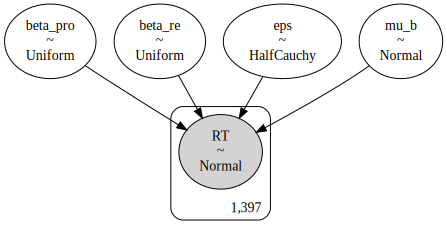

In [45]:
pm.model_graph.model_to_graphviz(model_0) #画出图模型

In [46]:
with model_0:
    trace1 = pm.sample(20000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta_re, beta_pro, mu_b]


/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 74 seconds.
The acceptance probability does not match the target. It is 0.8861615606809344, but should be close to 0.8. Try to increase the number of tuning steps.


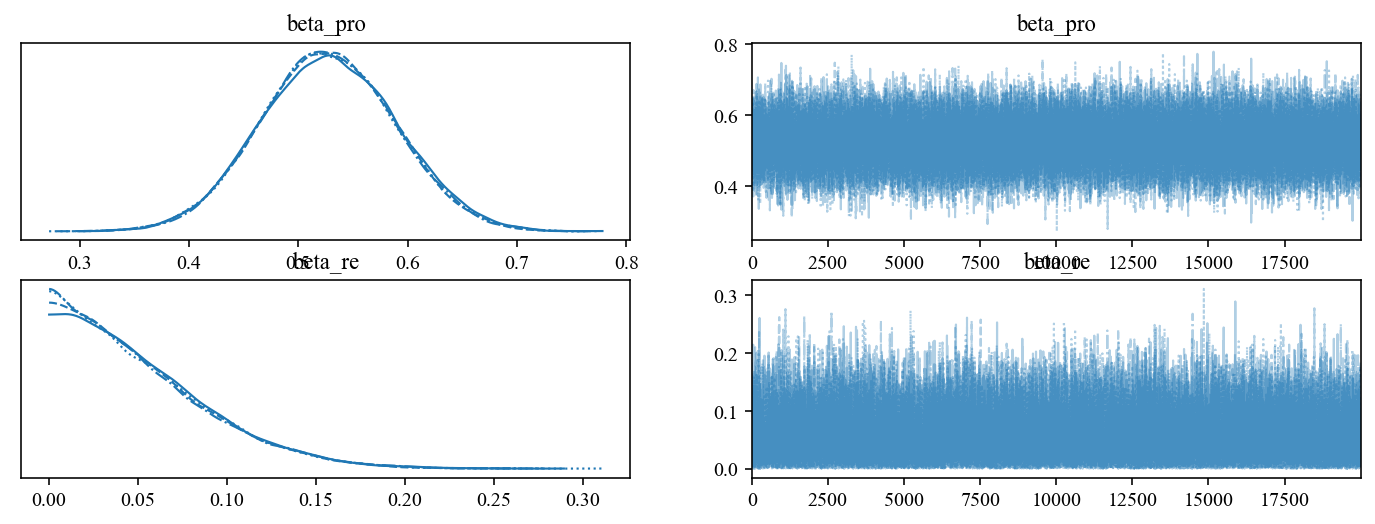

In [47]:
az.plot_trace(trace1, var_names=["beta_pro", "beta_re"])
plt.show()

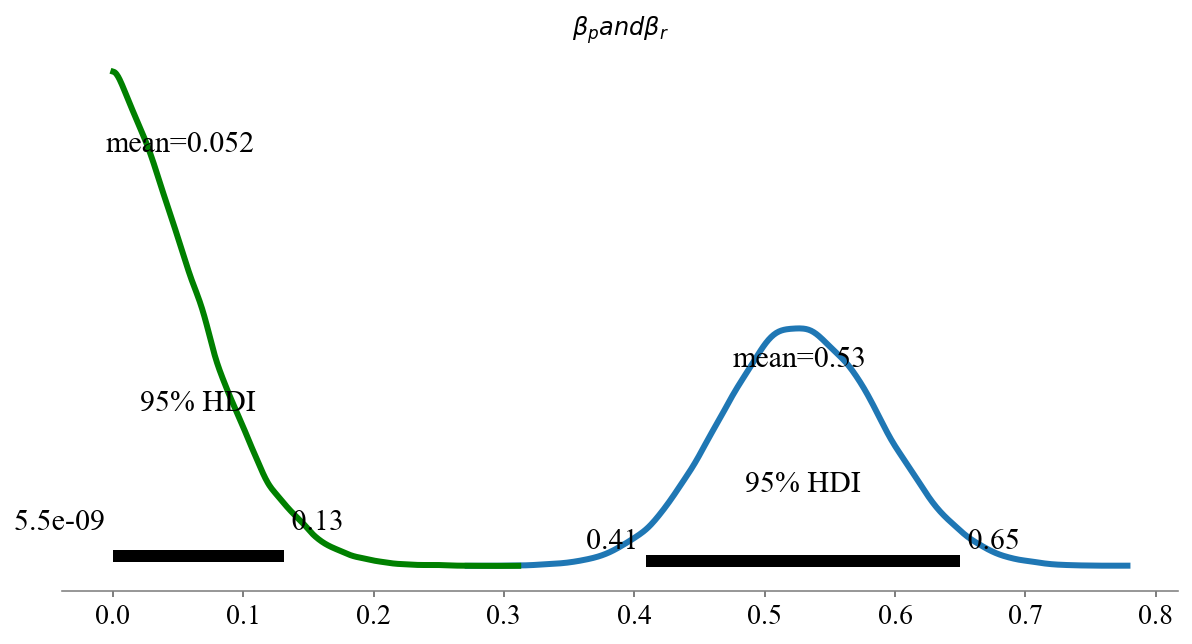

In [48]:
#画出总体beta_pro和beta_re均值的后验分布（其中b用绿色线表示，k用蓝色线表示）
_, ax= plt.subplots(figsize=(10, 5))
az.plot_posterior(trace1.posterior['beta_pro'], lw=3, hdi_prob=0.95, ax=ax)
az.plot_posterior(trace1.posterior['beta_re'], lw=3, hdi_prob=0.95, ax=ax, color = 'green')
ax.set_title(r'$\beta_p and \beta_r$')
plt.show()

------

In [187]:
data_control = data1[data1.inter+data1.noise+data1.motiv+data1.masked==0]

In [188]:
data_control

,Unnamed: 0,RT,true,inter,motiv,masked,noise,ID,type,eta_pro,eta_re
0,1,634.781100,1,0,0,0,0,1,1,-90,0
1,2,538.203300,1,0,0,0,0,1,2,90,-90
2,3,512.262000,1,0,0,0,0,1,1,-90,0
3,4,456.118800,1,0,0,0,0,1,1,-90,0
4,5,511.307800,1,0,0,0,0,1,1,-90,0
...,...,...,...,...,...,...,...,...,...,...,...
458,2476,347.851008,1,0,0,0,0,10,4,-90,-90
459,2477,361.276490,1,0,0,0,0,10,4,-90,-90
460,2478,621.954926,1,0,0,0,0,10,4,-90,-90
461,2479,363.020762,1,0,0,0,0,10,4,-90,-90


In [189]:
subject_idxs, subject = pd.factorize(data_control.ID)
coords = {
    "subject": subject,
    "obs_id": np.arange(len(subject_idxs)),
}

In [190]:
# define model
with pm.Model(coords = coords) as model_control:
    b = pm.Normal("mu_b", mu=400, sigma=50)
    beta_pro = pm.Uniform("beta_pro",lower=0,upper=1)
    beta_re = pm.Uniform("beta_re",lower=0,upper=1)
    y = b + data_control['eta_pro'].values * beta_pro + data_control['eta_re'].values * beta_re
    
    eps = pm.HalfCauchy("eps", 5)
    RT = pm.Normal("RT",y,sigma=eps,observed = data_control.RT, dims = "obs_id")

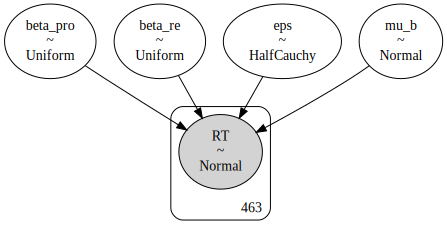

In [206]:
pm.model_graph.model_to_graphviz(model_control) #画出图模型

In [191]:
with model_control:
    trace1 = pm.sample(20000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta_re, beta_pro, mu_b]


/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 98 seconds.


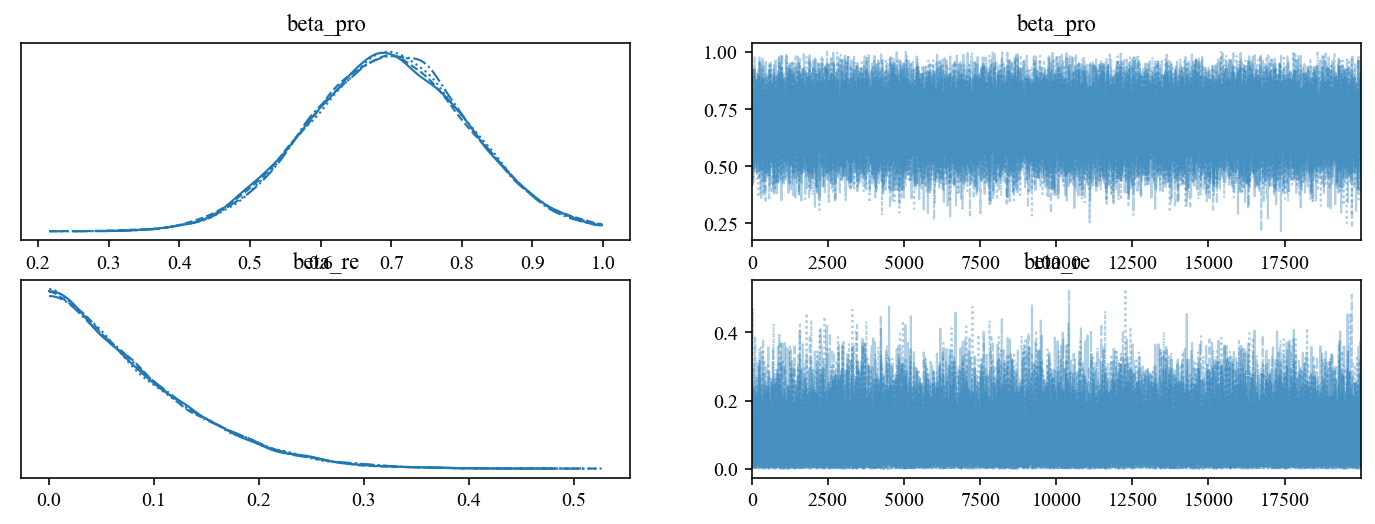

In [192]:
az.plot_trace(trace1, var_names=["beta_pro", "beta_re"])
plt.show()

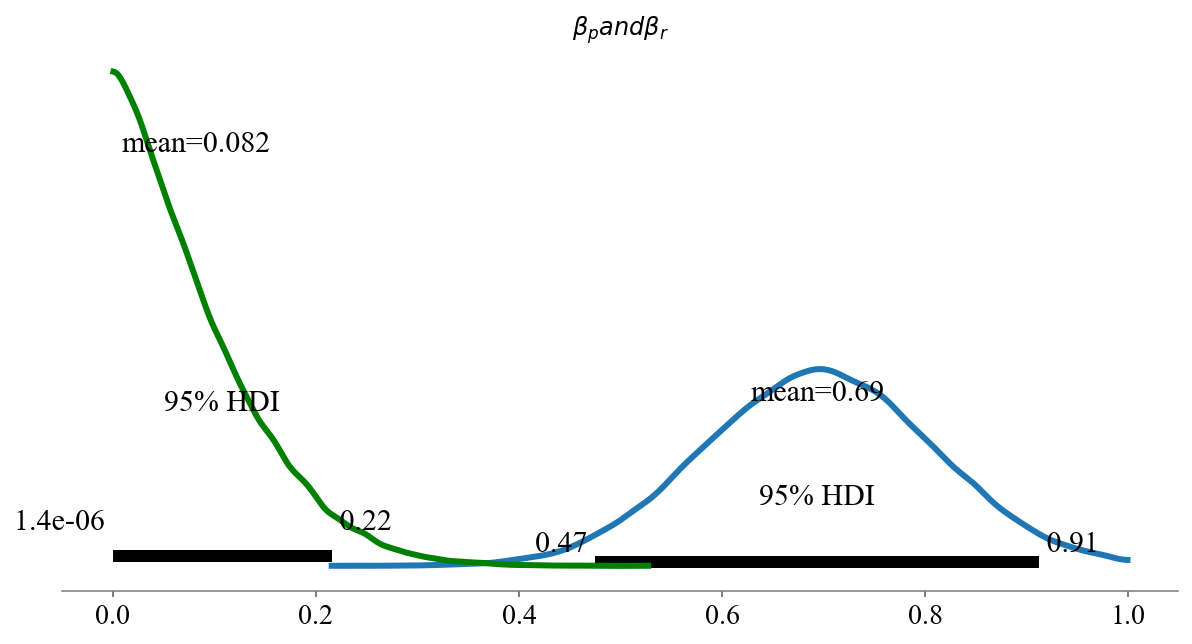

In [193]:
#画出总体beta_pro和beta_re均值的后验分布（其中b用绿色线表示，k用蓝色线表示）
_, ax= plt.subplots(figsize=(10, 5))
az.plot_posterior(trace1.posterior['beta_pro'], lw=3, hdi_prob=0.95, ax=ax)
az.plot_posterior(trace1.posterior['beta_re'], lw=3, hdi_prob=0.95, ax=ax, color = 'green')
ax.set_title(r'$\beta_p and \beta_r$')
plt.show()

-----

In [84]:
data_inter = data1[data1.inter==1]

In [85]:
data_inter

,RT,inter,noise,ID,type,eta_pro,eta_re
928,590.965838,1,0,1,1,-90.0,0.0
929,491.020240,1,0,1,1,-90.0,0.0
930,381.677569,1,0,1,1,-90.0,0.0
931,580.035309,1,0,1,2,90.0,-90.0
932,592.735143,1,0,1,2,90.0,-90.0
...,...,...,...,...,...,...,...
1392,353.991220,1,0,10,4,-90.0,-90.0
1393,384.312092,1,0,10,4,-90.0,-90.0
1394,463.787084,1,0,10,4,-90.0,-90.0
1395,460.306083,1,0,10,4,-90.0,-90.0


In [86]:
subject_idxs, subject = pd.factorize(data_inter.ID)
coords = {
    "subject": subject,
    "obs_id": np.arange(len(subject_idxs)),
}

In [87]:
# define model
with pm.Model(coords = coords) as model_inter:
    b = pm.Normal("mu_b", mu=400, sigma=50)
    beta_pro = pm.Uniform("beta_pro",lower=0,upper=1)
    beta_re = pm.Uniform("beta_re",lower=0,upper=1)
    y = b + data_inter['eta_pro'].values * beta_pro + data_inter['eta_re'].values * beta_re
    
    eps = pm.HalfCauchy("eps", 5)
    RT = pm.Normal("RT",y,sigma=eps,observed = data_inter.RT, dims = "obs_id")

In [88]:
with model_inter:
    trace1 = pm.sample(20000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta_re, beta_pro, mu_b]


/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 74 seconds.


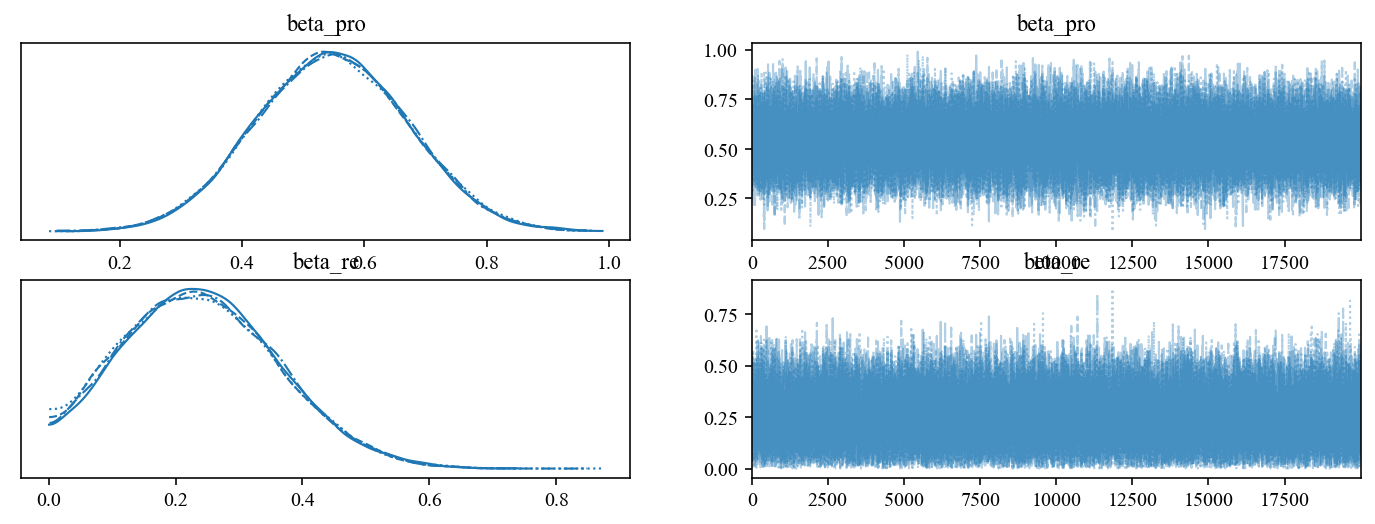

In [89]:
az.plot_trace(trace1, var_names=["beta_pro", "beta_re"])
plt.show()

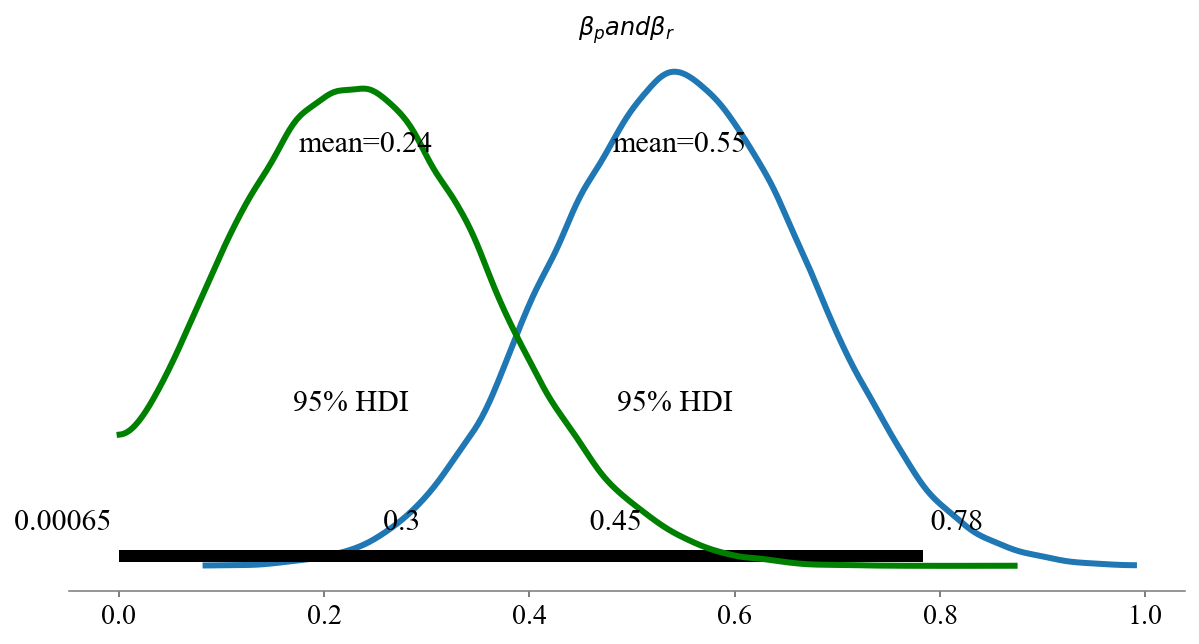

In [90]:
#画出总体beta_pro和beta_re均值的后验分布（其中b用绿色线表示，k用蓝色线表示）
_, ax= plt.subplots(figsize=(10, 5))
az.plot_posterior(trace1.posterior['beta_pro'], lw=3, hdi_prob=0.95, ax=ax)
az.plot_posterior(trace1.posterior['beta_re'], lw=3, hdi_prob=0.95, ax=ax, color = 'green')
ax.set_title(r'$\beta_p and \beta_r$')
plt.show()

------

In [91]:
data_noise = data1[data1.noise==1]

In [92]:
data_noise

,RT,inter,noise,ID,type,eta_pro,eta_re
463,620.818400,0,1,1,1,-90.0,0.0
464,975.740100,0,1,1,1,-90.0,0.0
465,500.228500,0,1,1,1,-90.0,0.0
466,499.911300,0,1,1,1,-90.0,0.0
467,395.890400,0,1,1,4,-90.0,-90.0
...,...,...,...,...,...,...,...
923,353.236588,0,1,10,4,-90.0,-90.0
924,313.949012,0,1,10,4,-90.0,-90.0
925,445.879026,0,1,10,4,-90.0,-90.0
926,330.612364,0,1,10,4,-90.0,-90.0


In [95]:
subject_idxs, subject = pd.factorize(data_noise.ID)
coords = {
    "subject": subject,
    "obs_id": np.arange(len(subject_idxs)),
}

In [96]:
# define model
with pm.Model(coords = coords) as model_noise:
    b = pm.Normal("mu_b", mu=400, sigma=50)
    beta_pro = pm.Uniform("beta_pro",lower=0,upper=1)
    beta_re = pm.Uniform("beta_re",lower=0,upper=1)
    y = b + data_noise['eta_pro'].values * beta_pro + data_noise['eta_re'].values * beta_re
    
    eps = pm.HalfCauchy("eps", 5)
    RT = pm.Normal("RT",y,sigma=eps,observed = data_noise.RT, dims = "obs_id")

In [100]:
with model_noise:
    trace1 = pm.sample(20000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta_re, beta_pro, mu_b]


/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 94 seconds.


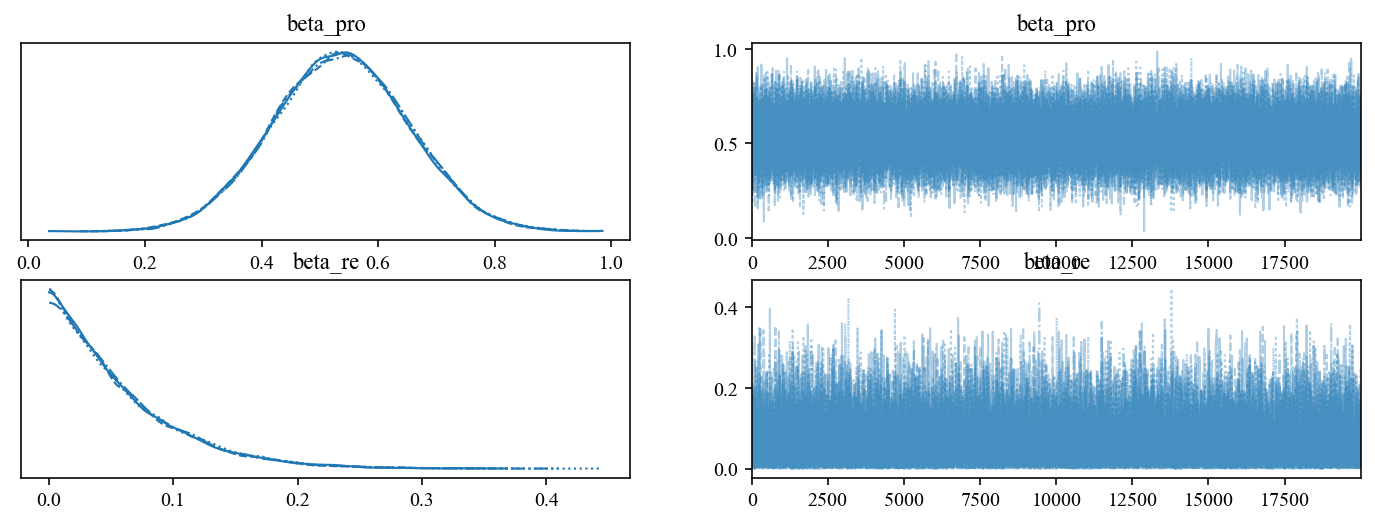

In [101]:
az.plot_trace(trace1, var_names=["beta_pro", "beta_re"])
plt.show()

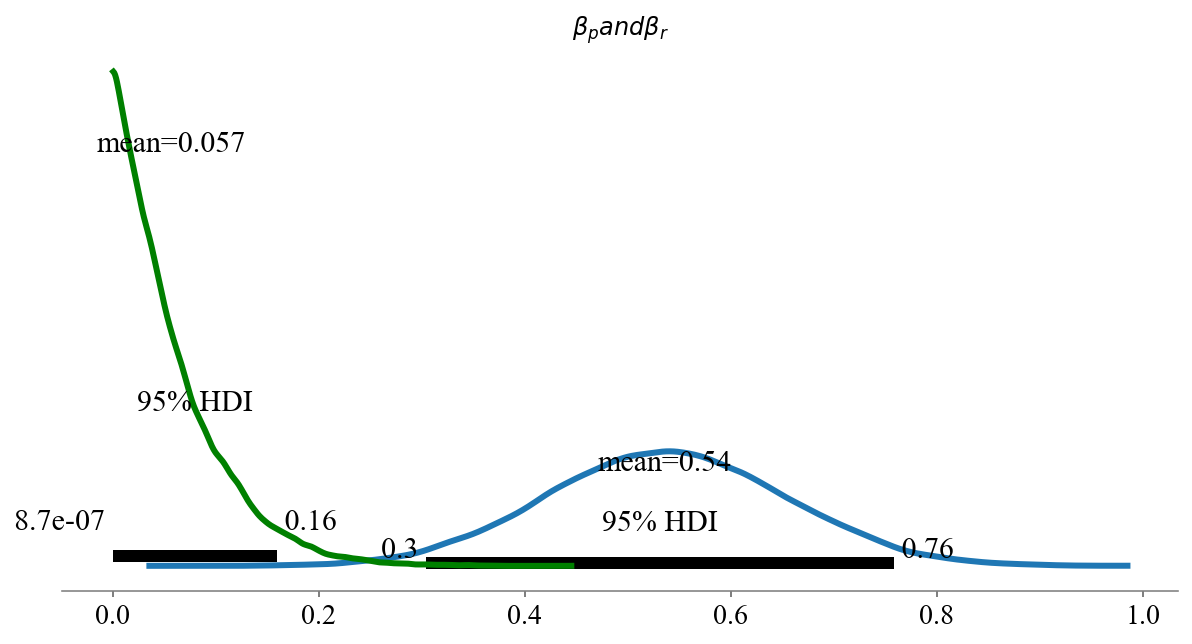

In [102]:
#画出总体beta_pro和beta_re均值的后验分布（其中b用绿色线表示，k用蓝色线表示）
_, ax= plt.subplots(figsize=(10, 5))
az.plot_posterior(trace1.posterior['beta_pro'], lw=3, hdi_prob=0.95, ax=ax)
az.plot_posterior(trace1.posterior['beta_re'], lw=3, hdi_prob=0.95, ax=ax, color = 'green')
ax.set_title(r'$\beta_p and \beta_r$')
plt.show()

-----

In [121]:
data_motiv = data1[data1.motiv==1]

In [122]:
data_motiv

,Unnamed: 0,RT,true,inter,motiv,masked,noise,ID,type,eta_pro,eta_re
1397,201,653.906600,1,0,1,0,0,1,1,-90,0
1398,202,374.479600,1,0,1,0,0,1,1,-90,0
1399,203,349.827300,1,0,1,0,0,1,1,-90,0
1400,204,429.508600,1,0,1,0,0,1,1,-90,0
1401,205,356.746600,1,0,1,0,0,1,1,-90,0
...,...,...,...,...,...,...,...,...,...,...,...
1877,2481,490.473867,1,0,1,0,0,10,4,-90,-90
1878,2482,353.675407,1,0,1,0,0,10,4,-90,-90
1879,2483,392.460024,1,0,1,0,0,10,4,-90,-90
1880,2484,389.517215,1,0,1,0,0,10,4,-90,-90


In [123]:
subject_idxs, subject = pd.factorize(data_motiv.ID)
coords = {
    "subject": subject,
    "obs_id": np.arange(len(subject_idxs)),
}

In [124]:
# define model
with pm.Model(coords = coords) as model_motiv:
    b = pm.Normal("mu_b", mu=400, sigma=50)
    beta_pro = pm.Uniform("beta_pro",lower=0,upper=1)
    beta_re = pm.Uniform("beta_re",lower=0,upper=1)
    y = b + data_motiv['eta_pro'].values * beta_pro + data_motiv['eta_re'].values * beta_re
    
    eps = pm.HalfCauchy("eps", 5)
    RT = pm.Normal("RT",y,sigma=eps,observed = data_motiv.RT, dims = "obs_id")

In [126]:
with model_motiv:
    trace1 = pm.sample(20000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta_re, beta_pro, mu_b]


/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 100 seconds.


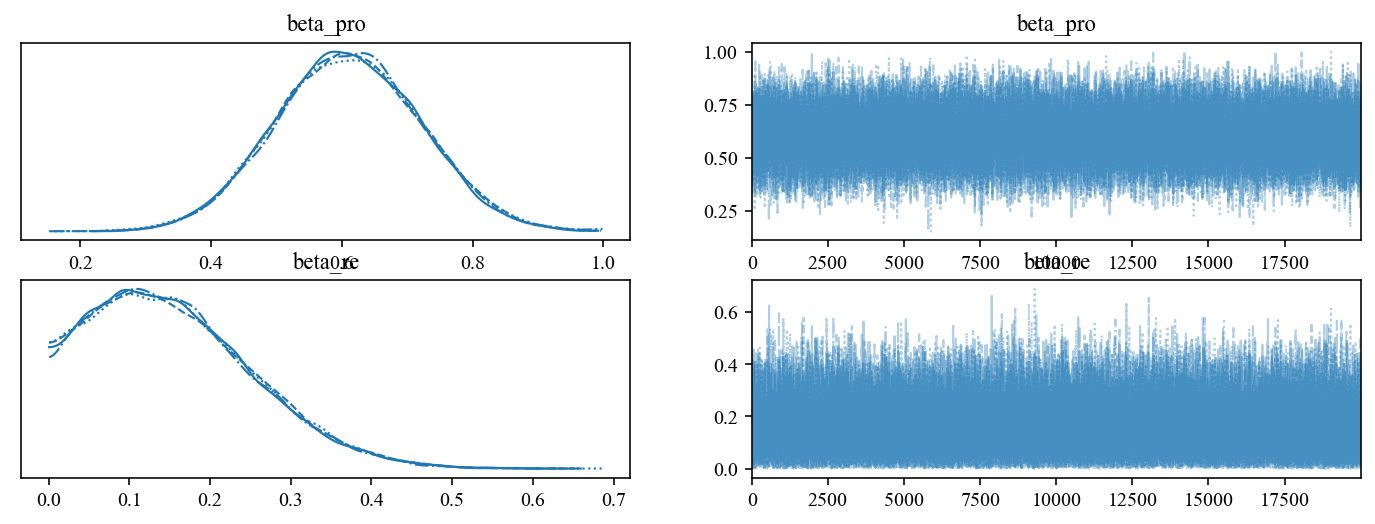

In [127]:
az.plot_trace(trace1, var_names=["beta_pro", "beta_re"])
plt.show()

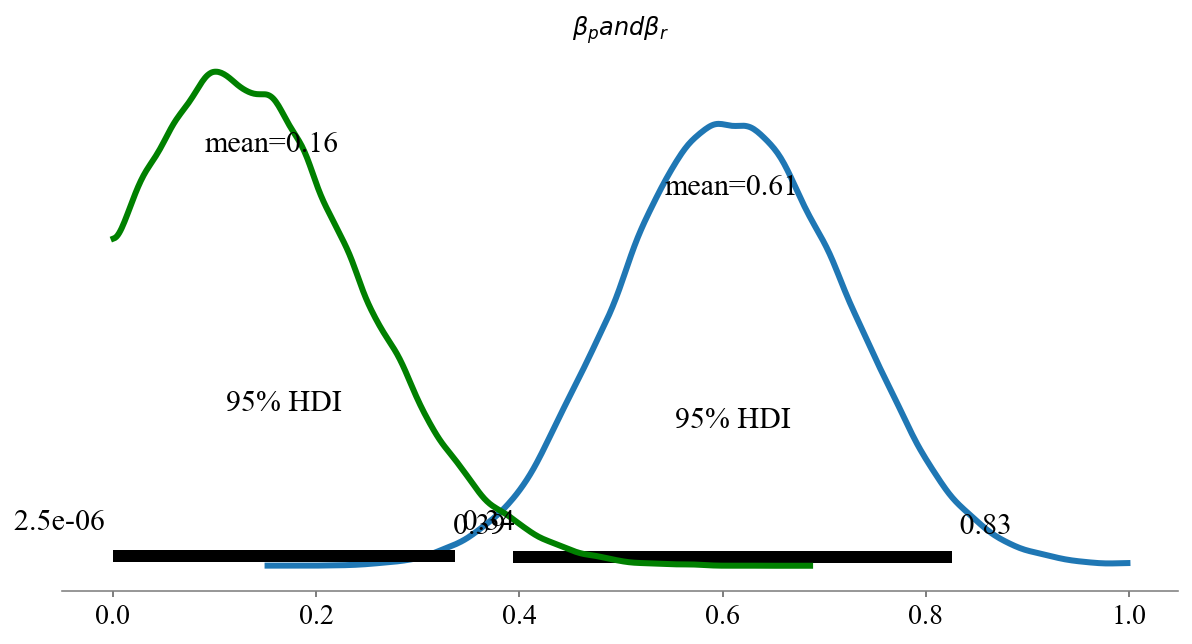

In [128]:
#画出总体beta_pro和beta_re均值的后验分布（其中b用绿色线表示，k用蓝色线表示）
_, ax= plt.subplots(figsize=(10, 5))
az.plot_posterior(trace1.posterior['beta_pro'], lw=3, hdi_prob=0.95, ax=ax)
az.plot_posterior(trace1.posterior['beta_re'], lw=3, hdi_prob=0.95, ax=ax, color = 'green')
ax.set_title(r'$\beta_p and \beta_r$')
plt.show()

-----

In [129]:
data_masked = data1[data1.masked==1]

In [130]:
data_masked

,Unnamed: 0,RT,true,inter,motiv,masked,noise,ID,type,eta_pro,eta_re
1882,101,679.484600,1,0,0,1,0,1,1,-90,0
1883,102,463.920500,1,0,0,1,0,1,1,-90,0
1884,103,311.312800,1,0,0,1,0,1,1,-90,0
1885,104,367.614800,1,0,0,1,0,1,4,-90,-90
1886,105,454.419700,1,0,0,1,0,1,3,-90,90
...,...,...,...,...,...,...,...,...,...,...,...
2353,2486,344.195769,1,0,0,1,0,10,4,-90,-90
2354,2487,359.948543,1,0,0,1,0,10,4,-90,-90
2355,2488,351.888270,1,0,0,1,0,10,4,-90,-90
2356,2489,344.257520,1,0,0,1,0,10,4,-90,-90


In [131]:
subject_idxs, subject = pd.factorize(data_masked.ID)
coords = {
    "subject": subject,
    "obs_id": np.arange(len(subject_idxs)),
}

In [132]:
# define model
with pm.Model(coords = coords) as model_masked:
    b = pm.Normal("mu_b", mu=400, sigma=50)
    beta_pro = pm.Uniform("beta_pro",lower=0,upper=1)
    beta_re = pm.Uniform("beta_re",lower=0,upper=1)
    y = b + data_masked['eta_pro'].values * beta_pro + data_masked['eta_re'].values * beta_re
    
    eps = pm.HalfCauchy("eps", 5)
    RT = pm.Normal("RT",y,sigma=eps,observed = data_masked.RT, dims = "obs_id")

In [133]:
with model_masked:
    trace1 = pm.sample(20000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta_re, beta_pro, mu_b]


/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 100 seconds.
The acceptance probability does not match the target. It is 0.8814883285713062, but should be close to 0.8. Try to increase the number of tuning steps.


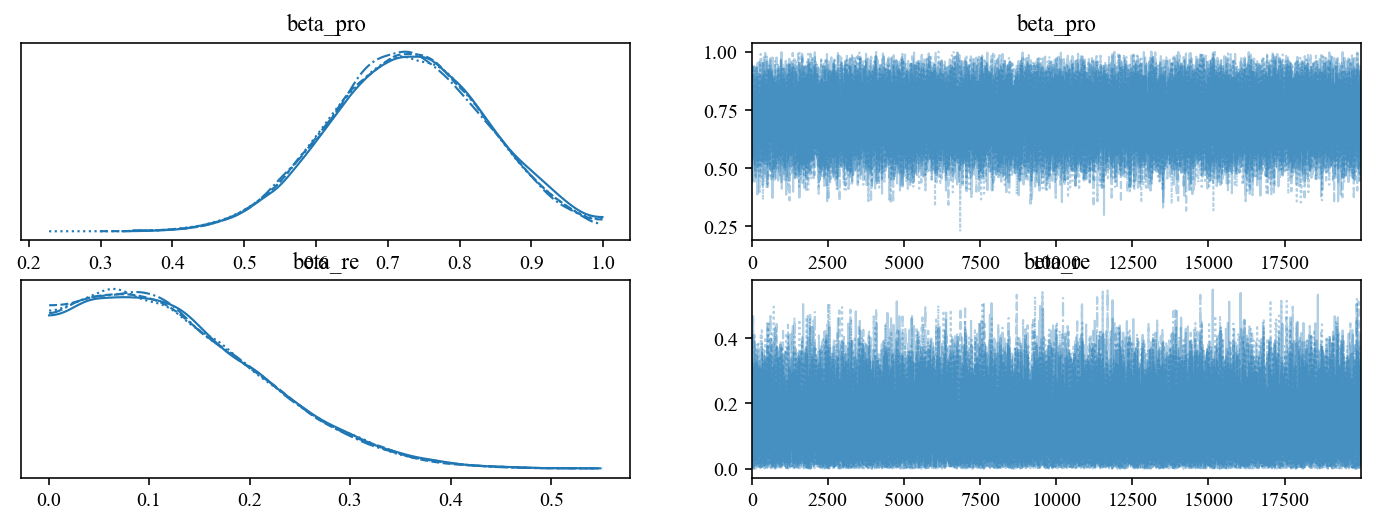

In [134]:
az.plot_trace(trace1, var_names=["beta_pro", "beta_re"])
plt.show()

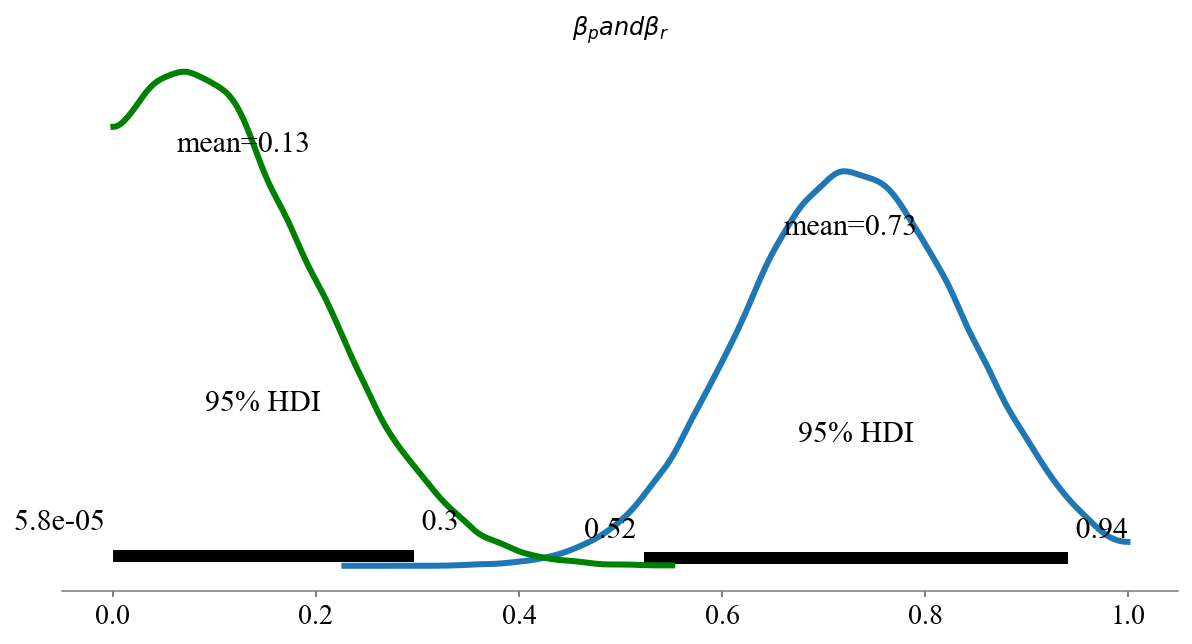

In [135]:
#画出总体beta_pro和beta_re均值的后验分布（其中b用绿色线表示，k用蓝色线表示）
_, ax= plt.subplots(figsize=(10, 5))
az.plot_posterior(trace1.posterior['beta_pro'], lw=3, hdi_prob=0.95, ax=ax)
az.plot_posterior(trace1.posterior['beta_re'], lw=3, hdi_prob=0.95, ax=ax, color = 'green')
ax.set_title(r'$\beta_p and \beta_r$')
plt.show()

------

In [195]:
data_control = data1[data1.inter+data1.noise+data1.motiv+data1.masked==0]

In [196]:
data_control

,Unnamed: 0,RT,true,inter,motiv,masked,noise,ID,type,eta_pro,eta_re
0,1,634.781100,1,0,0,0,0,1,1,-90,0
1,2,538.203300,1,0,0,0,0,1,2,90,-90
2,3,512.262000,1,0,0,0,0,1,1,-90,0
3,4,456.118800,1,0,0,0,0,1,1,-90,0
4,5,511.307800,1,0,0,0,0,1,1,-90,0
...,...,...,...,...,...,...,...,...,...,...,...
458,2476,347.851008,1,0,0,0,0,10,4,-90,-90
459,2477,361.276490,1,0,0,0,0,10,4,-90,-90
460,2478,621.954926,1,0,0,0,0,10,4,-90,-90
461,2479,363.020762,1,0,0,0,0,10,4,-90,-90


In [197]:
subject_idxs, subject = pd.factorize(data_control.ID)
coords = {
    "subject": subject,
    "obs_id": np.arange(len(subject_idxs)),
}

In [198]:
# define model
with pm.Model(coords = coords) as model_control_sub:
    subject_idxs = pm.Data("subject_idxs", subject_idxs, dims="obs_id") #定义分组
    b = pm.Normal("mu_b", mu=400, sigma=50, dims="subject")
    beta_pro = pm.Uniform("beta_pro",lower=0,upper=1, dims="subject")
    beta_re = pm.Uniform("beta_re",lower=0,upper=1,dims="subject")
    y = b[subject_idxs] + data_control['eta_pro'].values * beta_pro[subject_idxs] + data_control['eta_re'].values * beta_re[subject_idxs]
    
    eps = pm.HalfCauchy("eps", 5)
    RT = pm.Normal("RT",y,sigma=eps,observed = data_control.RT, dims = "obs_id")
    

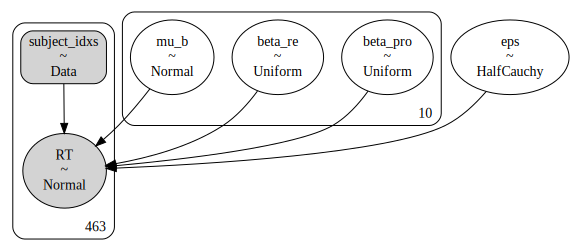

In [199]:
pm.model_graph.model_to_graphviz(model_control_sub) #画出图模型

In [200]:
with model_control_sub:
    trace1 = pm.sample(20000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta_re, beta_pro, mu_b]


/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 146 seconds.


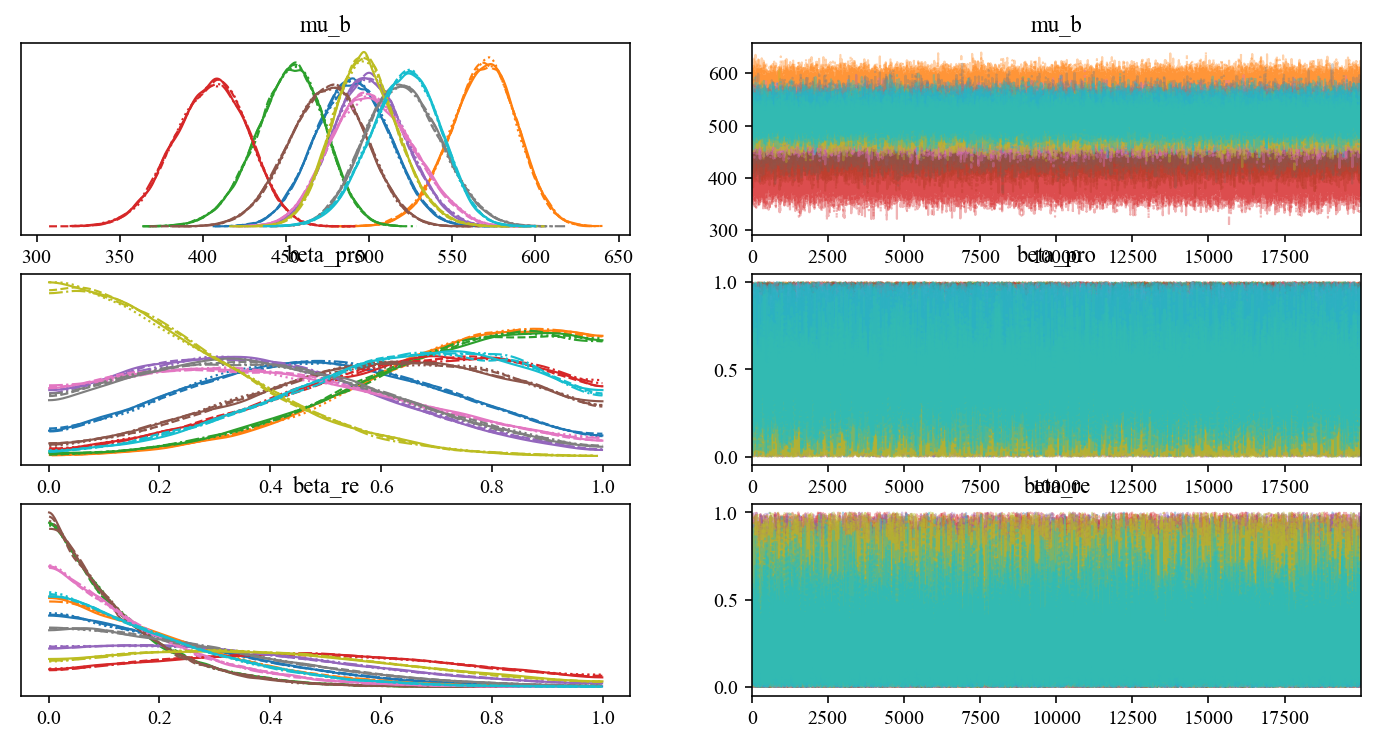

In [201]:
az.plot_trace(trace1, var_names=["mu_b","beta_pro", "beta_re"],coords={"subject": subject[:10]})
plt.show()

In [202]:
subject = []
b = []
beta_pro = []
beta_re = []

In [203]:
for i in range(1,11):
    subject.append(i)
    b.append(trace1.posterior.sel(subject=i)['mu_b'].values.mean())
    beta_pro.append(trace1.posterior.sel(subject=i)['beta_pro'].values.mean())
    beta_re.append(trace1.posterior.sel(subject=i)['beta_re'].values.mean())

In [204]:
result = pd.DataFrame({'subject':subject,'b':b,'beta_pro':beta_pro,'beta_re':beta_re})

In [205]:
result

,subject,b,beta_pro,beta_re
0,1,490.176459,0.485087,0.235467
1,2,568.206916,0.718300,0.199695
2,3,452.167286,0.708846,0.124488
3,4,404.687795,0.633837,0.465400
4,5,500.360980,0.379576,0.338462
5,6,474.769233,0.589663,0.122926
6,7,502.295511,0.403872,0.161918
7,8,520.443992,0.396104,0.267571
8,9,498.057339,0.231106,0.393867
9,10,521.368823,0.635739,0.194765


------

In [176]:
data_inter = data1[data1.inter==1]

In [177]:
data_inter

,Unnamed: 0,RT,true,inter,motiv,masked,noise,ID,type,eta_pro,eta_re
928,152,590.965838,1,1,0,0,0,1,1,-90,0
929,153,491.020241,1,1,0,0,0,1,1,-90,0
930,154,381.677569,1,1,0,0,0,1,1,-90,0
931,155,580.035309,1,1,0,0,0,1,2,90,-90
932,156,592.735143,1,1,0,0,0,1,2,90,-90
...,...,...,...,...,...,...,...,...,...,...,...
1392,2496,353.991220,1,1,0,0,0,10,4,-90,-90
1393,2497,384.312092,1,1,0,0,0,10,4,-90,-90
1394,2498,463.787084,1,1,0,0,0,10,4,-90,-90
1395,2499,460.306083,1,1,0,0,0,10,4,-90,-90


In [178]:
subject_idxs, subject = pd.factorize(data_inter.ID)
coords = {
    "subject": subject,
    "obs_id": np.arange(len(subject_idxs)),
}

In [179]:
# define model
with pm.Model(coords = coords) as model_inter_sub:
    subject_idxs = pm.Data("subject_idxs", subject_idxs, dims="obs_id") #定义分组
    b = pm.Normal("mu_b", mu=400, sigma=50, dims="subject")
    beta_pro = pm.Uniform("beta_pro",lower=0,upper=1, dims="subject")
    beta_re = pm.Uniform("beta_re",lower=0,upper=1,dims="subject")
    y = b[subject_idxs] + data_inter['eta_pro'].values * beta_pro[subject_idxs] + data_inter['eta_re'].values * beta_re[subject_idxs]
    
    eps = pm.HalfCauchy("eps", 5)
    RT = pm.Normal("RT",y,sigma=eps,observed = data_inter.RT, dims = "obs_id")
    

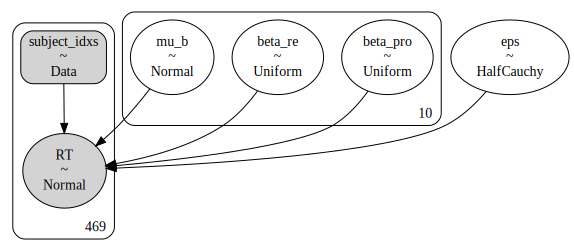

In [180]:
pm.model_graph.model_to_graphviz(model_inter_sub) #画出图模型

In [181]:
with model_inter_sub:
    trace1 = pm.sample(20000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta_re, beta_pro, mu_b]


/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zhaolong/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 165 seconds.


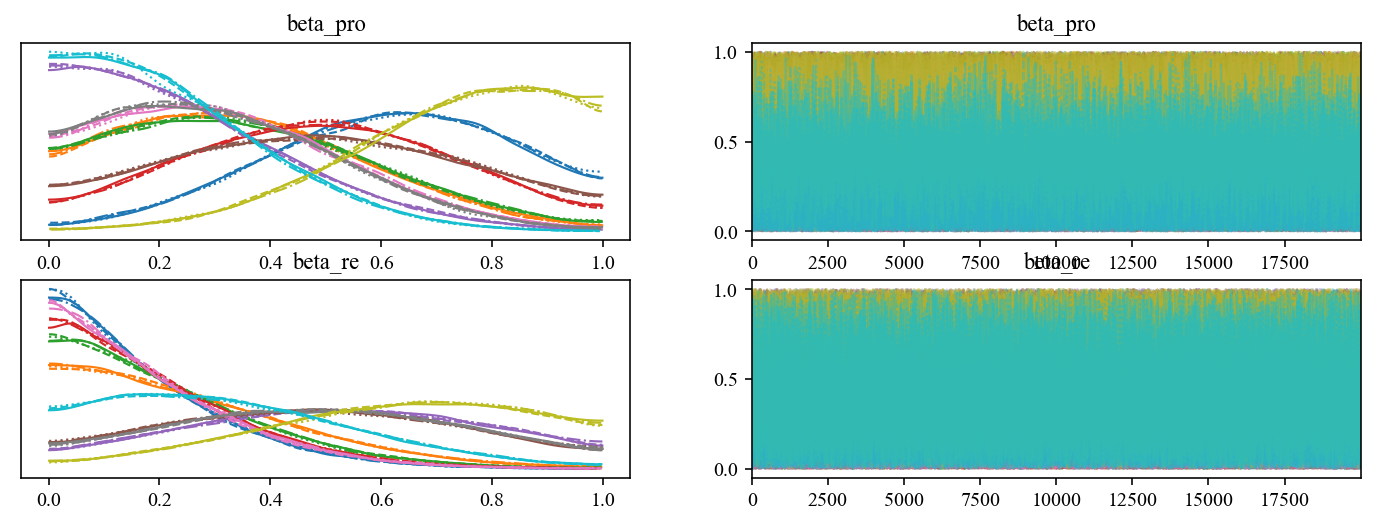

In [182]:
az.plot_trace(trace1, var_names=["beta_pro", "beta_re"],coords={"subject": subject[:10]})
plt.show()

In [183]:
subject = []
b = []
beta_pro = []
beta_re = []

In [184]:
for i in range(1,11):
    subject.append(i)
    b.append(trace1.posterior.sel(subject=i)['mu_b'].values.mean())
    beta_pro.append(trace1.posterior.sel(subject=i)['beta_pro'].values.mean())
    beta_re.append(trace1.posterior.sel(subject=i)['beta_re'].values.mean())

In [185]:
result = pd.DataFrame({'subject':subject,'b':b,'beta_pro':beta_pro,'beta_re':beta_re})

In [186]:
result

,subject,b,beta_pro,beta_re
0,1,508.191602,0.605339,0.180401
1,2,637.567408,0.359985,0.267301
2,3,470.397737,0.368201,0.221378
3,4,442.820095,0.489238,0.201107
4,5,531.439162,0.262887,0.516198
5,6,450.750733,0.485340,0.481236
6,7,493.723206,0.330366,0.190908
7,8,467.475063,0.323257,0.487401
8,9,508.123481,0.715021,0.614415
9,10,486.901216,0.238074,0.336862
